In [13]:
# =================================================================================================
# 1. SETUP & LOAD DATA (MENGGUNAKAN PREPROCESS YANG SUDAH ADA)
# =================================================================================================

# Memanggil file preprocess.ipynb agar variabel train_ds, val_ds, test_generator tersedia
# Pastikan file preprocess.ipynb berada di folder yang sama
%run preprocess.ipynb

import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
from datetime import datetime

==================PROSES PEMUATAN DATASET==================

[1/3] Memuat dataset_final\train
Found 1200 files belonging to 4 classes.



[2/3] Memuat dataset_final\val
Found 87 files belonging to 4 classes.

[3/3] Memuat dataset_final\test
Found 90 files belonging to 4 classes.

==================INFORMASI KELAS & MAPPING==================
Kelas ditemukan: ['1', '2', '3', '4']

Index Model     | Nama Folder     | Nilai PPB (Target)  
------------------------------------------------------------
0               | 1               | 0                   
1               | 2               | 1                   
2               | 3               | 2                   
3               | 4               | 3                   

Selesai. Dataset siap digunakan.
Step 2: Setting up data augmentation...
✓ RandomFlip (horizontal)
✓ RandomRotation (±10°)
✓ Preprocessing applied to all datasets


In [14]:
# =================================================================================================
# 2. KONFIGURASI EKSPERIMEN (UBAH PARAMETER DI SINI SETIAP KALI RUNNING)
# =================================================================================================
# Ini adalah "Control Panel" kamu. Ubah angka di sini, lalu Run All.

# --- Parameter Arsitektur Model ---
DENSE_UNITS = 256           # Jumlah neuron di layer klasifikasi baru. Semakin besar = model makin kompleks.
DROPOUT_RATE = 0.3          # 0.5 artinya 50% neuron dimatikan acak saat training utk cegah overfitting.
FINE_TUNE_AT = 140          # Layer ResNet (total ~170+) mulai dari mana kita 'cairkan' untuk dilatih ulang.
                            # Semakin kecil angkanya, semakin banyak layer yang dilatih ulang (lebih lama & butuh data banyak).

# --- Parameter Training Phase 1 (Feature Extraction - Base Model Beku) ---
LR_PHASE_1 = 1e-3           # Learning Rate awal (biasanya 1e-3 atau 1e-4).
EPOCHS_PHASE_1 = 2         # Epoch pemanasan.

# --- Parameter Training Phase 2 (Fine Tuning - Base Model Cair Sebagian) ---
LR_PHASE_2 = 1e-5           # LR harus jauuuh lebih kecil (misal 1e-5) agar bobot pre-trained tidak rusak ("Catastrophic Forgetting").
EPOCHS_PHASE_2 = 2         # Epoch lanjutan.

# --- Lainnya ---
BATCH_SIZE = 32             # Jumlah gambar yang diproses sekali jalan.
OPTIMIZER_NAME = 'Adam'     # Pilihan: 'Adam', 'SGD', 'RMSprop'.
LOG_FILE_PATH = 'experiment_log_aflatoxin.csv' # Nama file untuk menyimpan hasil otomatis.

In [15]:
# =================================================================================================
# 3. MEMBANGUN MODEL (ARSITEKTUR RESNET)
# =================================================================================================

def build_model_experiment():
    # Menggunakan ResNet50 sebagai base (Transfer Learning)
    # include_top=False artinya kita buang layer klasifikasi bawaan (1000 kelas ImageNet)
    base_model = ResNet50(
        weights='imagenet', # Use pre-trained weights
        include_top=False, # Exclude top classification layer
        input_tensor=Input(shape=(224, 224, 3)))
    
    # Freeze Base Model: Kita kunci bobot ResNet agar tidak berubah di Fase 1
    base_model.trainable = False

    # Membuat "Kepala" baru (Custom Head) sesuai kasus Aflatoxin (4 Kelas)
    head = base_model.output
    head = GlobalAveragePooling2D()(head) # Mengubah tensor 3D menjadi vektor 1D (rata-rata)
    head = Dense(DENSE_UNITS, activation='relu')(head)
    head = Dropout(DROPOUT_RATE)(head)    # Dropout penting jika dataset kecil (<10k gambar)
    output = Dense(4, activation='softmax')(head) # 4 Kelas, Softmax untuk probabilitas

    model = Model(inputs=base_model.input, outputs=output)
    return model, base_model

# Inisialisasi Model
model, base_model = build_model_experiment()

# Setup Optimizer Dinamis sesuai Konfigurasi
if OPTIMIZER_NAME.lower() == 'adam':
    opt = Adam(learning_rate=LR_PHASE_1)
elif OPTIMIZER_NAME.lower() == 'sgd':
    opt = SGD(learning_rate=LR_PHASE_1)
else:
    opt = RMSprop(learning_rate=LR_PHASE_1)

model.compile(
    optimizer=opt, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

print(f"\n[INFO] Model dibangun dengan Optimizer: {OPTIMIZER_NAME} | LR Awal: {LR_PHASE_1}")
print(f"✓ Optimizer: {OPTIMIZER_NAME} | LR Awal: {LR_PHASE_1}")
print(f"✓ Loss: sparse_categorical_crossentropy")
print(f"✓ Metrics: accuracy")
print(f"Model compiled successfully!")
print(f"\nTotal parameters: {model.count_params():,}")

# Display model architecture
# model.summary()


[INFO] Model dibangun dengan Optimizer: Adam | LR Awal: 0.001
✓ Optimizer: Adam | LR Awal: 0.001
✓ Loss: sparse_categorical_crossentropy
✓ Metrics: accuracy
Model compiled successfully!

Total parameters: 24,113,284


In [ ]:
print("Step 2: Setting up training callbacks...")

# Training callbacks for better training control
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15, #jumlah epoch yg ditunggu
        mode='max', #accuracy higher is better
        restore_best_weights=True, 
        verbose=1 #menampilkan pesan di konsol saat pelatihan dihentikan
    ), # Stop training if no improvement in validation loss
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5, #kurangi LR 50%
        patience=10,
        min_lr=1e-8,
        verbose=1
    ), # Reduce learning rate if no improvement
    tf.keras.callbacks.ModelCheckpoint(
        'best_aflatoxin_classifier.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ) # Save best model
]

print("✓ EarlyStopping (monitor='val_accuracy', patience=15)")
print("✓ ReduceLROnPlateau (factor=0.5, patience=10)")
print("✓ ModelCheckpoint (save best model)")

Step 2: Setting up training callbacks...
✓ EarlyStopping (monitor='val_accuracy', patience=15)
✓ ReduceLROnPlateau (factor=0.5, patience=10)
✓ ModelCheckpoint (save best model)


In [17]:
# =================================================================================================
# 4. TRAINING PHASE 1 (WARM UP)
# =================================================================================================
# Tujuannya agar layer Dense baru beradaptasi dengan fitur dari ResNet sebelum ResNet-nya kita utak-atik.

print(f"\n[INFO] === PHASE 1: Training Head Only ({EPOCHS_PHASE_1} Epochs) ===")

history_1 = model.fit(
    train_ds,
    # steps_per_epoch=len(train_ds), # Opsional di TF versi baru, otomatis dideteksi
    validation_data=val_ds,
    epochs= EPOCHS_PHASE_1,
    callbacks=callbacks,
    verbose=1
)


[INFO] === PHASE 1: Training Head Only (2 Epochs) ===
Epoch 1/2
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2946 - loss: 1.4689
Epoch 1: val_accuracy improved from None to 0.35632, saving model to best_aflatoxin_classifier.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.3567 - loss: 1.3569 - val_accuracy: 0.3563 - val_loss: 1.3795 - learning_rate: 0.0010
Epoch 2/2
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4487 - loss: 1.1905
Epoch 2: val_accuracy improved from 0.35632 to 0.44828, saving model to best_aflatoxin_classifier.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.4475 - loss: 1.1804 - val_accuracy: 0.4483 - val_loss: 1.2308 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


In [18]:
# =================================================================================================
# 5. TRAINING PHASE 2 (FINE TUNING)
# =================================================================================================
# Sekarang kita cairkan sebagian layer ResNet untuk menyesuaikan fitur spesifik (tekstur jagung/aflatoxin)

# --- LANGKAH PENTING: MUAT BOBOT TERBAIK DARI FASE 1 ---
try:
    # Memuat bobot terbaik yang tersimpan dari ModelCheckpoint Phase 1
    model.load_weights('best_aflatoxin_classifier.keras')
    print("✅ Bobot terbaik dari Phase 1 berhasil dimuat.")
except Exception as e:
    print(f"❌ Peringatan: Gagal memuat bobot dari best_aflatoxin_classifier.keras. Error: {e}")
    print("   Melanjutkan dengan bobot terakhir Phase 1.")
    
print(f"\n[INFO] === PHASE 2: Fine Tuning (Start Layer {FINE_TUNE_AT}, {EPOCHS_PHASE_2} Epochs) ===")

total_epochs = EPOCHS_PHASE_1+EPOCHS_PHASE_2
base_model.trainable = True # Unfreeze base model

# Freeze ulang layer-layer awal (Low-level features seperti garis/sudut biasanya sudah bagus)
# Kita hanya ingin melatih layer-layer akhir (High-level features)
for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

# Compile ulang wajib dilakukan setelah mengubah trainable status
# Gunakan LR yang SANGAT KECIL (LR_PHASE_2) agar gradien tidak "meledak"
if OPTIMIZER_NAME.lower() == 'adam':
    opt_ft = Adam(learning_rate=LR_PHASE_2)
elif OPTIMIZER_NAME.lower() == 'sgd':
    opt_ft = SGD(learning_rate=LR_PHASE_2)
else:
    opt_ft = RMSprop(learning_rate=LR_PHASE_2)

model.compile(
    optimizer=opt_ft, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=len(history_1.history['loss']),
    epochs=total_epochs,
    callbacks=callbacks,
    verbose=1
)

✅ Bobot terbaik dari Phase 1 berhasil dimuat.

[INFO] === PHASE 2: Fine Tuning (Start Layer 140, 2 Epochs) ===
Epoch 3/4
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3764 - loss: 1.7033
Epoch 3: val_accuracy did not improve from 0.44828
38/38 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.4108 - loss: 1.4915 - val_accuracy: 0.4253 - val_loss: 1.2826 - learning_rate: 1.0000e-05
Epoch 4/4
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4742 - loss: 1.1120
Epoch 4: val_accuracy did not improve from 0.44828
38/38 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.5025 - loss: 1.0831 - val_accuracy: 0.3448 - val_loss: 1.4414 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 3.


In [19]:
print("Step 5: Evaluation on data set...")

# Load model terbaik
model = tf.keras.models.load_model('best_aflatoxin_classifier.keras')

# Evaluasi
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"\n✓ Test Loss: {test_loss:.4f}")
print(f"✓ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Step 5: Evaluation on data set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4111 - loss: 1.1125

✓ Test Loss: 1.1125
✓ Test Accuracy: 0.4111 (41.11%)



[INFO] Melakukan Evaluasi Menyeluruh...
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step

Confusion Matrix:
[[16  2  1  0]
 [14  7 12  4]
 [ 1  5  8 10]
 [ 0  1  3  6]]
------------------------------------------------------------

Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

     Kelas 1     0.5161    0.8421    0.6400        19
     Kelas 2     0.4667    0.1892    0.2692        37
     Kelas 3     0.3333    0.3333    0.3333        24
     Kelas 4     0.3000    0.6000    0.4000        10

    accuracy                         0.4111        90
   macro avg     0.4040    0.4912    0.4106        90
weighted avg     0.4230    0.4111    0.3791        90

✅ Akurasi Test Akhir: 41.11%
✅ Rata-rata Confidence: 45.64%

🖼️ Gambar Confusion Matrix tersimpan di: history_plots\cm_20260117_183205_Acc41.1.png


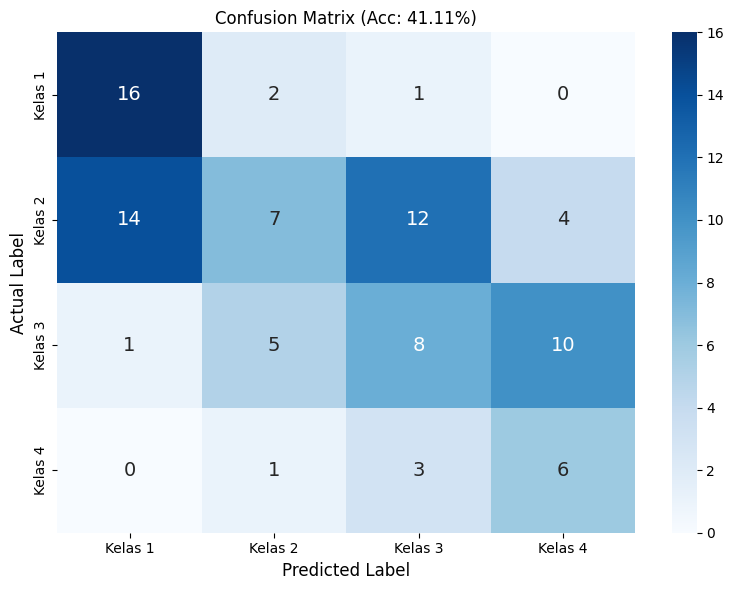

In [30]:
# =================================================================================================
# 6. EVALUASI DAN METRIK (OTOMATIS)
# =================================================================================================
print("\n[INFO] Melakukan Evaluasi Menyeluruh...")

# Prediksi (menghasilkan probabilitas, misal [0.1, 0.8, 0.05, 0.05])
Y_pred_probs = model.predict(test_ds, verbose=1)

# Ambil kelas dengan probabilitas tertinggi
y_pred = np.argmax(Y_pred_probs, axis=1)

# Label asli (Ground Truth)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
class_names = ['Kelas 1', 'Kelas 2', 'Kelas 3', 'Kelas 4']

# --- Metrik 1: Akurasi Global ---
test_acc = accuracy_score(y_true, y_pred)

# --- Metrik 2: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
# Kita simpan sebagai string list agar muat dalam 1 sel CSV: "[[10, 2], [1, 15]]"
cm_str = str(cm.tolist()) 
print("\nConfusion Matrix:")
print(cm)

# --- Metrik 3: Confidence Statistics ---
# Seberapa "PD" model kita? Apakah dia salah dengan yakin, atau salah karena ragu-ragu?
confidence_scores = np.max(Y_pred_probs, axis=1) # Ambil nilai probabilitas tertinggi tiap data
avg_conf = np.mean(confidence_scores)
min_conf = np.min(confidence_scores)
std_conf = np.std(confidence_scores)

# --- Metrik 4: Precision, Recall, F1 Per Kelas ---
# output_dict=True agar hasilnya bisa kita ambil per-variabel untuk CSV
report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
print("-" * 60)
print("\nClassification Report:")
print("-" * 60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print(f"✅ Akurasi Test Akhir: {test_acc*100:.2f}%")
print(f"✅ Rata-rata Confidence: {avg_conf*100:.2f}%")

import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
# Siapkan Folder Penyimpanan Gambar
plot_folder = "history_plots" 
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder) # Buat folder otomatis jika belum ada
# Buat Nama File Unik (Timestamp + Akurasi)
current_time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_filename = f"cm_{current_time_str}_Acc{test_acc*100:.1f}.png"
plot_filepath = os.path.join(plot_folder, plot_filename)
# Plotting & Saving
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 14})
# plt.title('Confusion Matrix - Klasifikasi Kadar Aflatoksin', fontsize=14)
plt.title(f'Confusion Matrix (Acc: {test_acc*100:.2f}%)')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

# SIMPAN GAMBAR SEBELUM plt.show()
plt.savefig(plot_filepath, dpi=300, bbox_inches='tight')
print(f"\n🖼️ Gambar Confusion Matrix tersimpan di: {plot_filepath}")

plt.show()

In [31]:
# =================================================================================================
# 7. SISTEM PENYIMPANAN LOG (AUTO-CSV)
# =================================================================================================
# Bagian ini yang akan menyimpan "Jejak Percobaan" kamu selamanya.

# Dictionary data untuk satu baris CSV
log_data = {
    # Waktu
    "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    
    # Parameter Setup (Apa yang kamu ubah di atas)
    "Optimizer": OPTIMIZER_NAME,
    "Batch_Size": BATCH_SIZE,
    "Dense_Units": DENSE_UNITS,
    "Dropout": DROPOUT_RATE,
    "Fine_Tune_At": FINE_TUNE_AT,
    
    # Parameter Training
    "LR_Phase_1": LR_PHASE_1,
    "Epochs_P1": EPOCHS_PHASE_1,
    "LR_Phase_2": LR_PHASE_2,
    "Epochs_P2": EPOCHS_PHASE_2,
    
    # Hasil Evaluasi Global
    "Accuracy": round(test_acc, 4),
    "Avg_Confidence": round(avg_conf, 4),
    "Min_Confidence": round(min_conf, 4),
    "Std_Confidence": round(std_conf, 4),
    "Confusion_Matrix": cm_str # Disimpan raw string
}

# Loop otomatis untuk mengambil Precision/Recall/F1 tiap kelas
# Ini membuat kolom dinamis: "Class_1ppb_Precision", "Class_2ppb_Recall", dst.
for label in class_names:
    metrics = report[label]
    log_data[f"Class_{label}_Prec"] = round(metrics['precision'], 4)
    log_data[f"Class_{label}_Rec"] = round(metrics['recall'], 4)
    log_data[f"Class_{label}_F1"] = round(metrics['f1-score'], 4)

# Buat DataFrame (1 baris)
df_new_log = pd.DataFrame([log_data])

# Logika Penyimpanan: Append (Tambah baris) jika file ada, Write (Buat baru) jika belum ada
if not os.path.exists(LOG_FILE_PATH):
    df_new_log.to_csv(LOG_FILE_PATH, index=False)
    print(f"\n[SAVE] File log baru dibuat: {LOG_FILE_PATH}")
else:
    df_new_log.to_csv(LOG_FILE_PATH, mode='a', header=False, index=False)
    print(f"\n[SAVE] Hasil percobaan berhasil ditambahkan ke: {LOG_FILE_PATH}")

print("="*60)
print("PROSES SELESAI. SILAKAN UBAH PARAMETER DI ATAS UNTUK PERCOBAAN BERIKUTNYA.")
print("="*60)


[SAVE] File log baru dibuat: experiment_log_aflatoxin.csv
PROSES SELESAI. SILAKAN UBAH PARAMETER DI ATAS UNTUK PERCOBAAN BERIKUTNYA.
